In [1]:
# Script to look at how qualitatively weird the fits are for the disproportionation tree

In [2]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline


sys.path.append('/home/moon/autoscience/reaction_calculator/database')
import database_fun

In [3]:
def get_node_std(rxns):
    recipe = database.kinetics.families['Disproportionation'].forward_recipe

    rxns = np.array(rxns)

    label = ''
    Tref = 1000.0
    data_mean = np.mean(np.log([r.kinetics.get_rate_coefficient(Tref) for r in rxns]))

    n = len(rxns)

    dlnks = np.array([
        np.log(
            rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {i})], recipe=recipe.actions)
            .to_arrhenius(rxn.get_enthalpy_of_reaction(Tref))
            .get_rate_coefficient(T=Tref) / rxn.get_rate_coefficient(T=Tref)
        ) for i, rxn in enumerate(rxns)
    ])


    varis = (np.array([rmgpy.kinetics.uncertainties.rank_accuracy_map[rxn.rank].value_si for rxn in rxns]) / (2.0 * 8.314 * Tref)) ** 2
    # weighted average calculations
    ws = 1.0 / varis
    V1 = ws.sum()
    V2 = (ws ** 2).sum()
    mu = np.dot(ws, dlnks) / V1
    s = np.sqrt(np.dot(ws, (dlnks - mu) ** 2) / (V1 - V2 / V1))

    kin_uncertainty = rmgpy.kinetics.uncertainties.RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=label)

    std_dev = kin_uncertainty.get_expected_log_uncertainty() / .398

    return std_dev

In [4]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log10(k)')

    if type(rxns) != list:
        rxns = [rxns]

    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log10(k))

    if labels:
        plt.legend(labels)
    plt.show()


## Load Database

In [5]:
database = rmgpy.data.rmg.RMGDatabase()

thermo_libraries = [
    'Klippenstein_Glarborg2016',
    'BurkeH2O2',
    'thermo_DFT_CCSDTF12_BAC', 
    'DFT_QCI_thermo',
    'primaryThermoLibrary',
    'primaryNS',
    'NitrogenCurran',
    'NOx2018',
    'FFCM1(-)',
    'SulfurLibrary',
    'SulfurGlarborgH2S',
    'SABIC_aromatics',
]

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libraries,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
    kinetics_families = 'all',
    kinetics_depositories = ['training'],
    #frequenciesLibraries = self.statmechLibraries,
    depository = False, # Don't bother loading the depository information, as we don't use it
)

In [6]:
# Load the model

# Must use annotated chemkin file
chemkin_file = 'RMG-MAX1/chem_annotated.inp'
dict_file = 'RMG-MAX1/species_dictionary.txt'

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_file, dict_file)


# Rebuild tree to get training reactions in each node

In [7]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
# for family_name in database.kinetics.families.keys():
for family_name in ['Disproportionation']:
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)


In [7]:
# Go through each node


for i, entry in enumerate(database.kinetics.families['Disproportionation'].rules.entries):
    node_name = str(database.kinetics.families['Disproportionation'].rules.entries[entry][0])
#     print(database.kinetics.families['Disproportionation'].rules.entries[entry][0])
    rxns = auto_gen_families['Disproportionation_rxn_map'][node_name]
    if len(rxns) > 1:
        print(i, len(rxns))

0 137
1 45
2 6
3 12
4 74
5 12
6 33
7 2
8 4
9 9
10 3
11 62
12 12
13 9
14 2
16 11
17 6
18 16
22 3
23 8
26 2
27 22
28 40
29 3
30 9
31 8
34 8
35 3
36 5
37 13
38 2
41 2
42 2
43 6
46 13
47 9
48 17
49 23
51 2
52 6
53 3
54 4
55 2
56 7
57 2
60 2
63 2
64 11
71 3
72 3
73 11
76 3
77 6
78 8
79 6
80 3
81 10
82 8
83 5
86 2
87 4
89 2
90 2
92 6
97 10
99 2
101 2
102 2
103 9
104 2
106 5
107 5
108 3
109 2
110 4
112 2
114 9
115 3
116 5
117 3
118 2
122 3
126 5
129 9
136 2
138 3
139 3
142 3
145 3
146 2
148 2
151 2
152 2
156 8
157 2
159 2
160 3
162 2
165 2
167 2
171 8
174 2
176 2
179 2
181 2
190 2
191 6
196 2
204 7
215 5
219 4
220 2
222 2
224 2
225 2
226 2


Root
N Train: 137


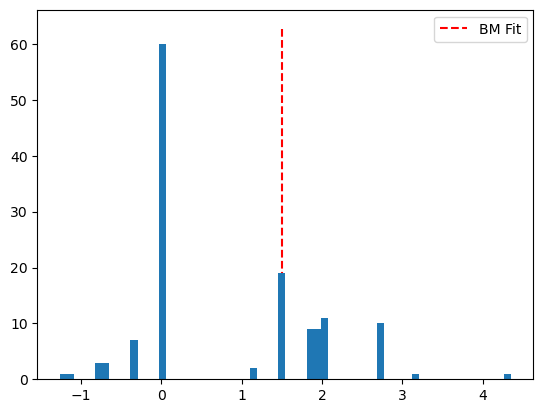

In [7]:
i = 0
node_names = list(database.kinetics.families['Disproportionation'].rules.entries)
node_name = node_names[i]
rxns = auto_gen_families['Disproportionation_rxn_map'][node_name]
print(node_name)
print(f'N Train: {len(rxns)}')


# make a histogram of all the n values
ns = [rxn.kinetics.n.value_si for rxn in rxns]
plt.hist(ns, 64)

n = database.kinetics.families['Disproportionation'].rules.entries[node_name][0].data.n.value_si
ax = plt.gca()
plt.vlines(n, ax.get_ylim()[0], ax.get_ylim()[1], color='red', label='BM Fit', zorder=0, linestyle='dashed')
plt.legend()

Root_Ext-1R!H-R_4R->O
N Train: 12


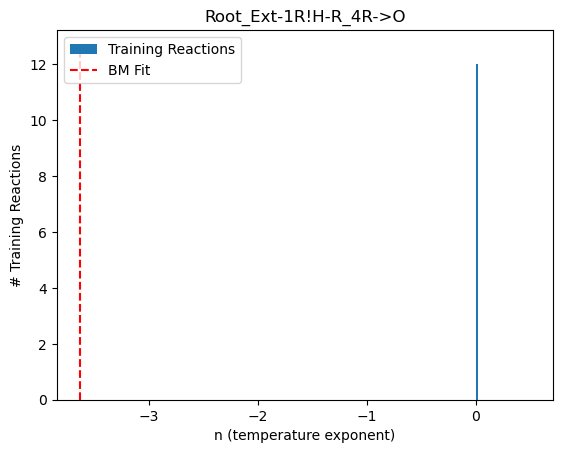

Root_Ext-2R!H-R_2R!H->C
N Train: 2


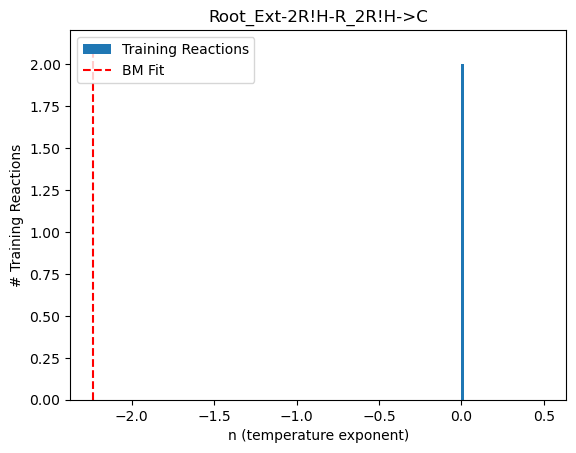

Root_Ext-1R!H-R_4R->O_Ext-4O-R
N Train: 9


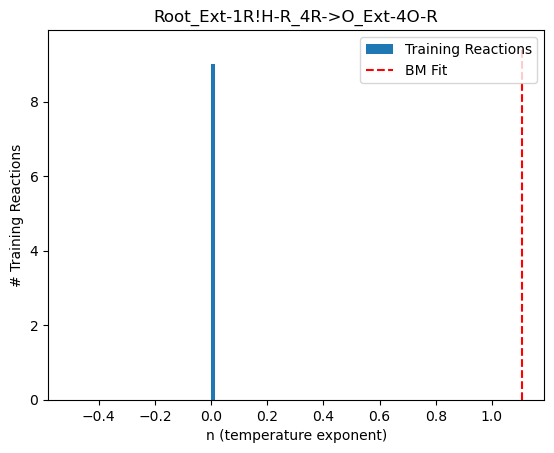

Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H
N Train: 6


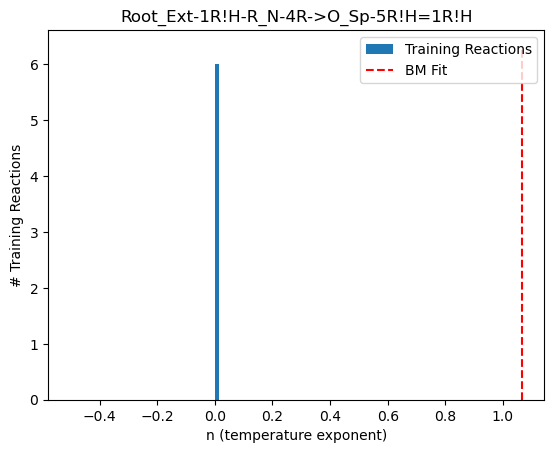

Root_Ext-2R!H-R_N-2R!H->C_N-4R->H
N Train: 3


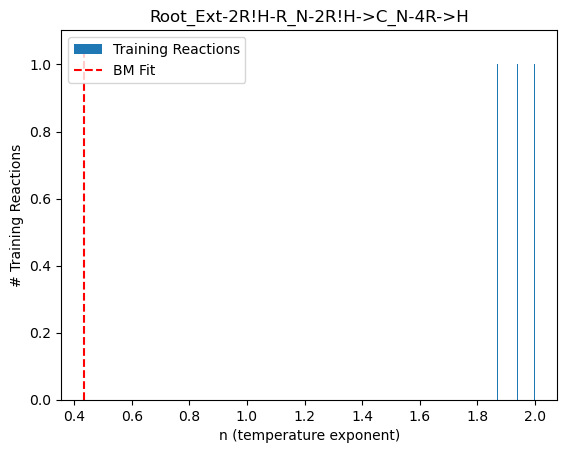

Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H_Ext-4CHNS-R_Ext-4CHNS-R
N Train: 2


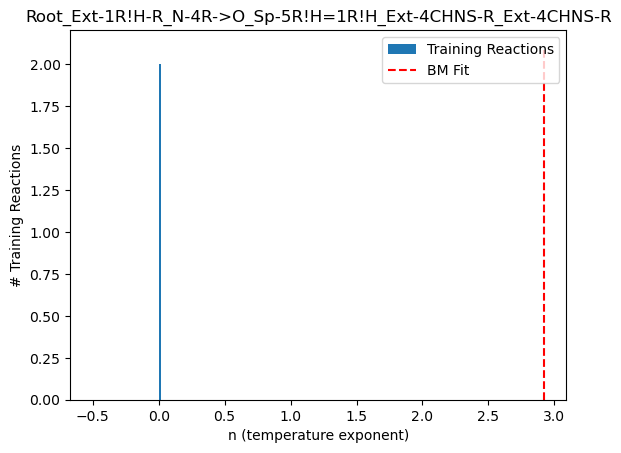

Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_6R!H->S
N Train: 2


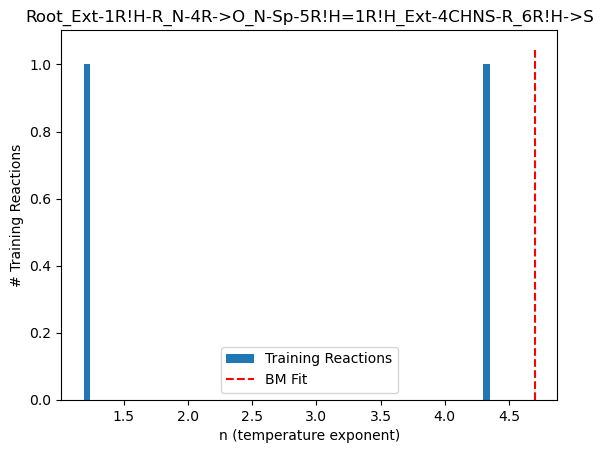

Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_4CNOS->O_Ext-4O-R
N Train: 2


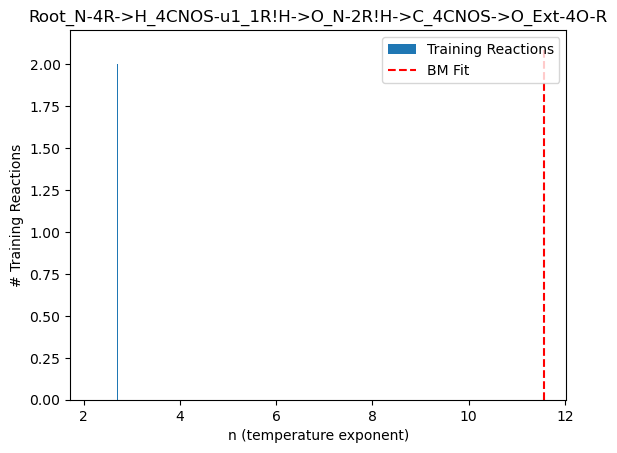

Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O_N-4CN->C_Ext-4N-R
N Train: 3


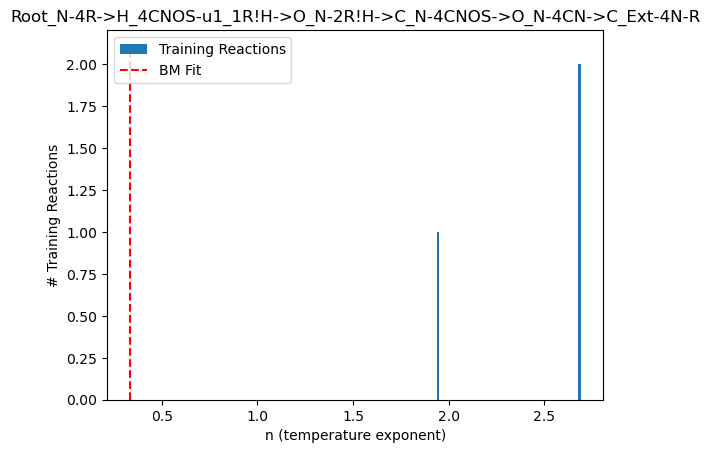

Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_4CNS->C_N-1CNS->C_N-2R!H->C_2NO-u1
N Train: 2


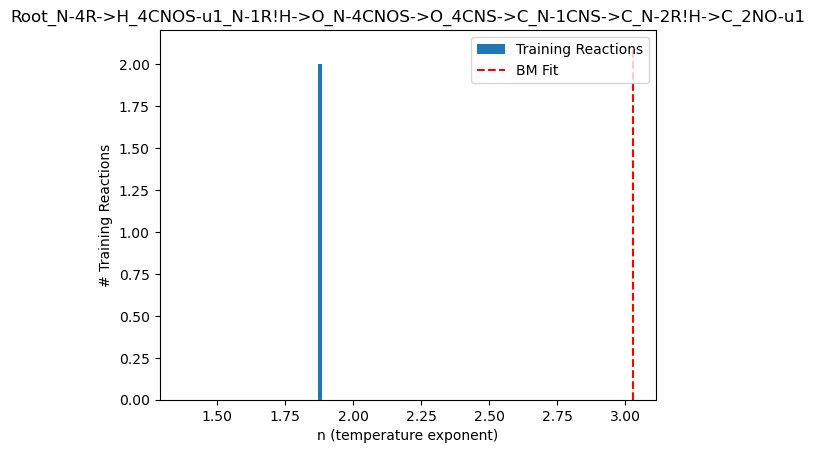

In [8]:

for i, entry in enumerate(database.kinetics.families['Disproportionation'].rules.entries):
    node_name = str(database.kinetics.families['Disproportionation'].rules.entries[entry][0])

    rxns = auto_gen_families['Disproportionation_rxn_map'][node_name]
    if len(rxns) < 2:
        continue

    rxns = auto_gen_families['Disproportionation_rxn_map'][node_name]
   
    # make a histogram of all the n values
    ns = [rxn.kinetics.n.value_si for rxn in rxns]
    n = database.kinetics.families['Disproportionation'].rules.entries[node_name][0].data.n.value_si
    
    
    # only show outliers
    if not (n > np.max(ns) or n < np.min(ns)):
        continue
    if np.abs(n - np.median(ns)) < 1.0:
        continue
    print(node_name)
    print(f'N Train: {len(rxns)}')
    plt.hist(ns, 64, label='Training Reactions')

    
    ax = plt.gca()
    plt.vlines(n, ax.get_ylim()[0], ax.get_ylim()[1], color='red', label='BM Fit', zorder=0, linestyle='dashed')
    plt.legend()
    plt.title(node_name)
    plt.xlabel('n (temperature exponent)')
    plt.ylabel('# Training Reactions')
    plt.show()

In [9]:
# let's retry fitting Node Root_Ext-1R!H-R_4R->O with a bound on the n value

node_name = 'Root_Ext-1R!H-R_4R->O'

rxns = auto_gen_families['Disproportionation_rxn_map'][node_name]

[print(rxn.kinetics.n.value_si) for rxn in rxns]

recipe = database.kinetics.families['Disproportionation'].forward_recipe


ns = [rxn.kinetics.n.value_si for rxn in rxns]
ub = np.max(ns) + 1.0
lb = np.min(ns) - 1.0
bounds = (np.array([-np.inf, lb, -np.inf]), np.array([np.inf, ub, np.inf]))

kin = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, bounds=bounds)
print(kin)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
using bounds
ArrheniusBM(A=(1.55125e+09,'m^3/(mol*s)'), n=-1, w0=(563000,'J/mol'), E0=(72555.9,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), comment="""Fitted to 12 reactions at temperatures: [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]""")


using bounds
Arrhenius(A=(1.78605e+06,'m^3/(mol*s)'), n=-0.1, Ea=(33.775,'kJ/mol'), T0=(1,'K'), Tmin=(300,'K'), Tmax=(2000,'K'), comment="""Fitted to 12 reactions at temperatures: [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]""")
no bounds


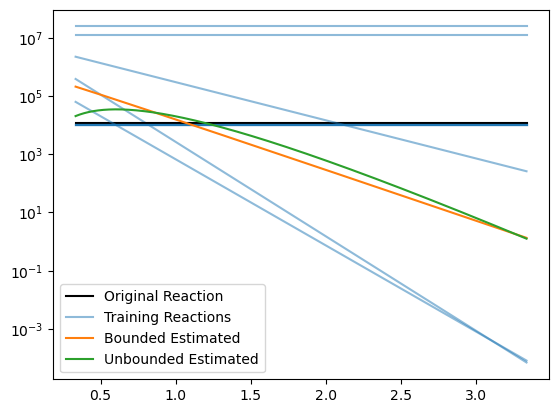

In [10]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
node = 'Root_Ext-1R!H-R_4R->O'

left_out_index = 2

Tref = 1000.0
T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    if z == left_out_index:
        plt.plot(1000.0 / T, k, color='black', label='Original Reaction')
    elif z == (left_out_index + 1) % len(auto_gen_families[f'{family}_rxn_map'][node]):
        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
    else:
        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
#     print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}')
     
plt.yscale('log')


# Estimate the kinetics using a bound
ns = [rxn.kinetics.n.value_si for rxn in rxns]
delta = 0.1
ub = np.max(ns) + delta
lb = np.min(ns) - delta
b0 = 0.0

bounds = (np.array([-np.inf, lb, -np.inf]), np.array([np.inf, ub, np.inf]))
# bounds = None
bounded_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, b0=b0, bounds=bounds)
bounded_kin = bounded_kin_BM.to_arrhenius(rxns[left_out_index].get_enthalpy_of_reaction(Tref))
print(bounded_kin)

k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = bounded_kin.get_rate_coefficient(T[j])
plt.plot(1000.0 / T, k, label='Bounded Estimated', color=colors[1])


unbounded_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)
unbounded_kin = unbounded_kin_BM.to_arrhenius(rxns[left_out_index].get_enthalpy_of_reaction(Tref))
k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = unbounded_kin.get_rate_coefficient(T[j])
plt.plot(1000.0 / T, k, label='Unbounded Estimated', color=colors[2])

plt.legend()
plt.show()

In [11]:
reaction_list[80]

In [12]:
database_fun.get_unique_reaction_index(reaction_list[80])

454

In [13]:
rxn_is = [80,
317,
348,
1187,
1810,
1823]

for i in rxn_is:
    print(database_fun.get_unique_reaction_index(reaction_list[i]))

454
477
478
1060
760
1534


In [14]:
reaction_list[80]

In [15]:
database_fun.index2reaction(454)

In [16]:
k454 = rmgpy.kinetics.arrhenius.Arrhenius(A=(395729,'cm^3/(mol*s)'), n=2.32986, Ea=(11.2826,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.08701, dn = +|- 0.0109608, dEa = +|- 0.0596481 kJ/mol""")

k1534 = rmgpy.kinetics.arrhenius.Arrhenius(A=(3.26248,'cm^3/(mol*s)'), n=3.26723, Ea=(25.1885,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.07646, dn = +|- 0.00968034, dEa = +|- 0.05268 kJ/mol""")

k760 = rmgpy.kinetics.arrhenius.Arrhenius(A=(1783.13,'cm^3/(mol*s)'), n=2.76633, Ea=(1.25501,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.08124, dn = +|- 0.0102616, dEa = +|- 0.0558434 kJ/mol""")

k1060 = rmgpy.kinetics.arrhenius.Arrhenius(A=(428120,'cm^3/(mol*s)'), n=2.21263, Ea=(3.06029,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.05851, dn = +|- 0.00747079, dEa = +|- 0.0406557 kJ/mol""")

In [17]:
k1534

Arrhenius(A=(3.26248,'cm^3/(mol*s)'), n=3.26723, Ea=(25.1885,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.07646, dn = +|- 0.00968034, dEa = +|- 0.05268 kJ/mol""")

# Compare to actual reaction calculations

using bounds
no bounds


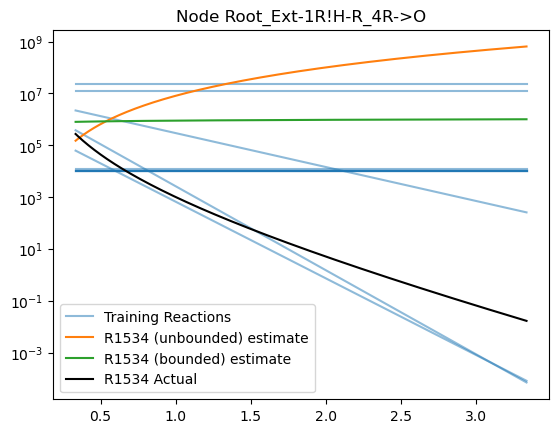

In [18]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
node = 'Root_Ext-1R!H-R_4R->O'


# Plot the training reactions
Tref = 1000.0
T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    if z == 0:
        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
    else:
        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
    plt.yscale('log')


# Estimate the kinetics using a bound
ns = [rxn.kinetics.n.value_si for rxn in rxns]
delta = 0.1
ub = np.max(ns) + delta
lb = np.min(ns) - delta
b0 = 0.0

bounds = (np.array([-np.inf, lb, -np.inf]), np.array([np.inf, ub, np.inf]))
bounded_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, b0=b0, bounds=bounds)
unbounded_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)
# unbounded_kin = unbounded_kin_BM.to_arrhenius(rxns[left_out_index].get_enthalpy_of_reaction(Tref))
# k = np.zeros(len(T))
# for j in range(0, len(T)):
#     k[j] = unbounded_kin.get_rate_coefficient(T[j])
# plt.plot(1000.0 / T, k, label='Unbounded Estimated', color=colors[2])



# next include the reactions matched by this node
# rxn_is = [80, 317, 348, 1187, 1810, 1823]

rxn_name = 'R454'
rxn_is = [80]
assert reaction_list[80].is_isomorphic(database_fun.index2reaction(454))

rxn_name = 'R1060'
rxn_is = [1187]
assert reaction_list[1187].is_isomorphic(database_fun.index2reaction(1060))

rxn_name = 'R760'
rxn_is = [1810]
assert reaction_list[1810].is_isomorphic(database_fun.index2reaction(760))

rxn_name = 'R1534'
rxn_is = [1823]
assert reaction_list[1823].is_isomorphic(database_fun.index2reaction(1534))

for i in rxn_is:
    
    bounded_kin = bounded_kin_BM.to_arrhenius(reaction_list[i].get_enthalpy_of_reaction(Tref))
    unbounded_kin = unbounded_kin_BM.to_arrhenius(reaction_list[i].get_enthalpy_of_reaction(Tref))
    
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = unbounded_kin.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'{rxn_name} (unbounded) estimate', color=colors[1])
    # also plot this estimate with the node's variance
    
    
    

    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = bounded_kin.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'{rxn_name} (bounded) estimate', color=colors[2])

    # 317 is 1534
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = k1534.get_rate_coefficient(T[j])  # 317
#         k[j] = k760.get_rate_coefficient(T[j])  # 1810
#         k[j] = k1060.get_rate_coefficient(T[j])  # 1187
#         k[j] = k454.get_rate_coefficient(T[j])  # 80
    plt.plot(1000.0 / T, k, label=f'{rxn_name} Actual', color='black')


plt.title(f'Node {node}')
plt.legend()
plt.show()

In [25]:
node = 'Root_Ext-1R!H-R_4R->O'
rxns = auto_gen_families[f'{family}_rxn_map'][node]

u = get_node_std(rxns)
u.get_expected_log_uncertainty() / .398

print(u.var)
print(u.get_expected_log_uncertainty() / .398)

# print the std dev


no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
2.6655742044913753
3.7941521125402273


In [27]:
reaction_list[1823].kinetics

Arrhenius(A=(5.50034e+24,'cm^3/(mol*s)'), n=-3.93, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_4R->O
Multiplied by reaction path degeneracy 2.0""")

In [32]:
database.kinetics.families['Disproportionation'].rules.entries[node][0].data

ArrheniusBM(A=(6.66628e+17,'m^3/(mol*s)'), n=-3.63731, w0=(563000,'J/mol'), E0=(85735.5,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), uncertainty=RateUncertainty(mu=0.20739942627141006, var=2.6655742044913753, Tref=1000.0, N=12, data_mean=0.0, correlation='Root_Ext-1R!H-R_4R->O',), comment="""BM rule fitted to 12 training reactions at node Root_Ext-1R!H-R_4R->O
    Total Standard Deviation in ln(k): 3.7941521125402273""")

# Plot with uncertainty

using bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds
no bounds


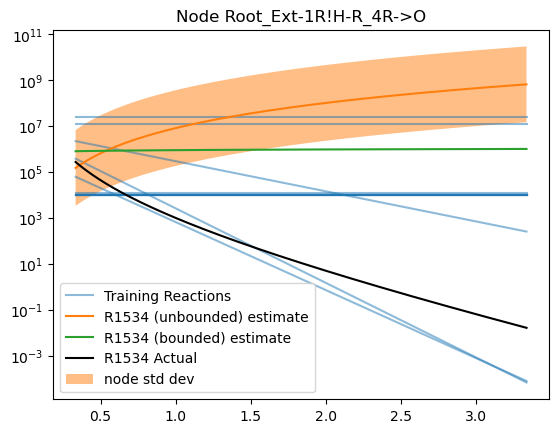

In [34]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
node = 'Root_Ext-1R!H-R_4R->O'


# Plot the training reactions
Tref = 1000.0
T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    if z == 0:
        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
    else:
        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
    plt.yscale('log')


# Estimate the kinetics using a bound
ns = [rxn.kinetics.n.value_si for rxn in rxns]
delta = 0.1
ub = np.max(ns) + delta
lb = np.min(ns) - delta
b0 = 0.0

bounds = (np.array([-np.inf, lb, -np.inf]), np.array([np.inf, ub, np.inf]))
bounded_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, b0=b0, bounds=bounds)
unbounded_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)


# next include the reactions matched by this node
# rxn_is = [80, 317, 348, 1187, 1810, 1823]

rxn_name = 'R454'
rxn_is = [80]
assert reaction_list[80].is_isomorphic(database_fun.index2reaction(454))

rxn_name = 'R1060'
rxn_is = [1187]
assert reaction_list[1187].is_isomorphic(database_fun.index2reaction(1060))

rxn_name = 'R760'
rxn_is = [1810]
assert reaction_list[1810].is_isomorphic(database_fun.index2reaction(760))

rxn_name = 'R1534'
rxn_is = [1823]
assert reaction_list[1823].is_isomorphic(database_fun.index2reaction(1534))

for i in rxn_is:
    
    bounded_kin = bounded_kin_BM.to_arrhenius(reaction_list[i].get_enthalpy_of_reaction(Tref))
    unbounded_kin = unbounded_kin_BM.to_arrhenius(reaction_list[i].get_enthalpy_of_reaction(Tref))
    
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = unbounded_kin.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'{rxn_name} (unbounded) estimate', color=colors[1])
    # also plot this estimate with the node's variance
    
    rxns = auto_gen_families[f'{family}_rxn_map'][node]
    sigma_lnk = get_node_std(rxns)
    sigma_k = np.exp(sigma_lnk)

    # Plot node std dev
    plt.fill_between(1000.0 / T, k, k * sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='node std dev')
    plt.fill_between(1000.0 / T, k / sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)


    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = bounded_kin.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'{rxn_name} (bounded) estimate', color=colors[2])

    # 317 is 1534
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = k1534.get_rate_coefficient(T[j])  # 317
#         k[j] = k760.get_rate_coefficient(T[j])  # 1810
#         k[j] = k1060.get_rate_coefficient(T[j])  # 1187
#         k[j] = k454.get_rate_coefficient(T[j])  # 80
    plt.plot(1000.0 / T, k, label=f'{rxn_name} Actual', color='black')


plt.title(f'Node {node}')
plt.legend()
plt.show()

In [ ]:
kin

In [ ]:
kin = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, b0=0.0)
print(kin)

In [ ]:
kin

In [ ]:
# Want to see if I can reproduce a node's rule using a recently regenerated Disproportionation Tree

nodes = list(database.kinetics.families['Disproportionation'].rules.entries)

node = nodes[0]
node = 'Root_Ext-1R!H-R_4R->O'

rxns = auto_gen_families['Disproportionation_rxn_map'][node]


recipe = database.kinetics.families['Disproportionation'].forward_recipe
kin = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)

In [ ]:
kin

In [ ]:
database.kinetics.families['Disproportionation'].rules.entries[node][0].data

In [ ]:
recipe = database.kinetics.families['Disproportionation'].forward_recipe
rxns = auto_gen_families['Disproportionation_rxn_map'][node]
rxns = np.array(rxns)

label = node
Tref = 1000.0
data_mean = np.mean(np.log([r.kinetics.get_rate_coefficient(Tref) for r in rxns]))

n = len(rxns)

dlnks = np.array([
    np.log(
        rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {i})], recipe=recipe.actions)
        .to_arrhenius(rxn.get_enthalpy_of_reaction(Tref))
        .get_rate_coefficient(T=Tref) / rxn.get_rate_coefficient(T=Tref)
    ) for i, rxn in enumerate(rxns)
])


varis = (np.array([rmgpy.kinetics.uncertainties.rank_accuracy_map[rxn.rank].value_si for rxn in rxns]) / (2.0 * 8.314 * Tref)) ** 2
# weighted average calculations
ws = 1.0 / varis
V1 = ws.sum()
V2 = (ws ** 2).sum()
mu = np.dot(ws, dlnks) / V1
s = np.sqrt(np.dot(ws, (dlnks - mu) ** 2) / (V1 - V2 / V1))

kin_uncertainty = rmgpy.kinetics.uncertainties.RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=label)


print(kin_uncertainty)

In [ ]:
kin_uncertainty.get_expected_log_uncertainty()

In [ ]:
kin_uncertainty.get_expected_log_uncertainty() / .398

In [ ]:
source[1][1]

# Plot Kinetics of a node

In [ ]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# node = list(auto_gen_families[f'{family}_rxn_map'].keys())[44]
node = 'Root_Ext-1R!H-R_4R->O'

# # Find nodes that matter
# for a in range(len(list(auto_gen_families[f'{family}_rxn_map'].keys()))):
#     node = list(auto_gen_families[f'{family}_rxn_map'].keys())[a]
#     reaction_indices = []
#     for z in range(len(reaction_list)):
#         if not hasattr(reaction_list[z], 'family') or reaction_list[z].family != family:
#             continue
#         source = database.kinetics.families[family].extract_source_from_comments(reaction_list[z])
#         if source[0]:
#             continue  # exact match
#         if source[1][1]['node'] == node:
#             reaction_indices.append(z)
#     if len(reaction_indices) > 0:
#         print(a, len(reaction_indices))



print(f'Node: {node}')
plt.xlabel('1000 / T (K^-1)')
plt.ylabel('k')


T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=z, color=colors[0], alpha=0.5)
    print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}')
    
    
# Also plot the average of the kinetics? Except that isn't even relevant to the BM tree?
# It's an approximation. Good enough for just looking at the trees

# Maybe I plot the reactions that are estimated using that node...
reaction_indices = []
for z in range(len(reaction_list)):
    if not hasattr(reaction_list[z], 'family') or reaction_list[z].family != family:
        continue
    source = database.kinetics.families[family].extract_source_from_comments(reaction_list[z])
    if source[0]:
        continue  # exact match
    if source[1][1]['node'] == node:
        print(z)
        # plot this reaction
        rxn = reaction_list[z]
        k = np.zeros(len(T))
        for j in range(0, len(T)):
            assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
            k[j] = rxn.get_rate_coefficient(T[j])
        plt.plot(1000.0 / T, k, label=z, color='black', alpha=0.1)
                
#                 break
#                 print(z)
# print(f'Reactions Estimated with node: {len(reaction_indices)}')            
    
plt.yscale('log')

# plt.legend()
plt.show()





In [ ]:
# Try getting a different fit:

node = 'Root_Ext-1R!H-R_4R->O'
rxns = auto_gen_families['Disproportionation_rxn_map'][node]


[print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}') for rxn in rxns] 

recipe = database.kinetics.families['Disproportionation'].forward_recipe
kin = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)


In [ ]:
kin

In [ ]:
kin2 = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, b0=0.0)

In [ ]:
kin2

In [ ]:
# plot the leave one out version

In [ ]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
node = 'Root_Ext-1R!H-R_4R->O'

left_out_index = 11

Tref = 1000.0
T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    if z == left_out_index:
        plt.plot(1000.0 / T, k, color='black', label='Original Left Out')
    elif z == (left_out_index + 1) % len(auto_gen_families[f'{family}_rxn_map'][node]):
        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
    else:
        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
#     print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}')
     
plt.yscale('log')


# Estimate the kinetics leaving out that reaction
rxns = np.array(rxns)
recipe = database.kinetics.families['Disproportionation'].forward_recipe
left_out_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {left_out_index})], recipe=recipe.actions)

left_out_kin = left_out_kin_BM.to_arrhenius(rxns[left_out_index].get_enthalpy_of_reaction(Tref))

k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = left_out_kin.get_rate_coefficient(T[j])
plt.plot(1000.0 / T, k, label='Left out Estimated', color=colors[1])

plt.legend()
plt.show()

In [ ]:
left_out_kin.to_arrhenius()

In [ ]:
rxn.get_enthalpy_of_reaction(Tref)

# Estimate reaction's kinetics

In [ ]:
z = 80
print(reaction_list[z].family)
display(reaction_list[z])
print(reaction_list[z].kinetics)

my_rxn = copy.deepcopy(reaction_list[z])

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

database.kinetics.families[reaction_list[z].family].add_atom_labels_for_reaction(my_rxn)

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

template_labels = database.kinetics.families[my_rxn.family].get_reaction_template_labels(my_rxn)
print(template_labels)
template = database.kinetics.families[my_rxn.family].retrieve_template(template_labels)
print(template)
print()

kinetics = database.kinetics.families[my_rxn.family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]
print(kinetics)

plot_kinetics([reaction_list[z], my_rxn], labels=['Original', 'refitted'])

In [ ]:
my_rxn.degeneracy


# Surface Family Example

In [ ]:
sfam = 'Surface_Adsorption_Single'
database.kinetics.families[sfam].rules.entries

In [ ]:
for entry in database.kinetics.families[sfam].groups.entries:
    print(database.kinetics.families[sfam].groups.entries[entry])

In [ ]:
database.kinetics.families[sfam].groups.entries

In [ ]:
# sample reaction

r1 = rmgpy.reaction.Reaction()
r1.reactants = []


In [ ]:
rmgpy.species.Species(
    smiles='[Pt]'
)